##Netflix Content Strategy Analysis##


### Objective
This project analyzes Netflix’s global content library to uncover patterns in content type, genre distribution, regional focus, and release strategies. It also integrates a content-based recommendation system to suggest similar shows or movies based on previously watched titles


Key questions explored include:

- Does Netflix prefer TV Shows or Movies?
- Which genres dominate in key markets like the US and India?
- Who are the most featured directors and actors?
- How has content addition evolved over the years?

###Why This Matters
For a streaming platform like Netflix, aligning content with audience preferences across countries and genres is key to user engagement and growth. This analysis can inform:
- Regional content strategies
- Talent partnerships (directors, actors)
- Seasonal release planning

###Dataset
- Source: [Kaggle Netflix Shows Dataset](https://www.kaggle.com/datasets/shivamb/netflix-shows)
- 8,807 entries × 12 columns
- Columns include: title, director, cast, country, date_added, rating, duration, listed_in (genre), release_year, etc.

###Tools Used
- Python (Pandas, NumPy)
- Data Visualization: Seaborn, Matplotlib
- Custom plotting functions for consistent visuals




###**IMPORTING DATA**

In [16]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility (optional unless using randomness)
random.seed(42)
np.random.seed(42)

# Download Kaggle dataset using kagglehub (you must authenticate via Kaggle API)
import kagglehub

# Download the dataset (caches by default)
dataset_path = kagglehub.dataset_download("shivamb/netflix-shows")

print("Dataset downloaded to:", dataset_path)

# Read the CSV file (assumes it's named 'netflix_titles.csv')
csv_path = os.path.join(dataset_path, "netflix_titles.csv")
df = pd.read_csv(csv_path)

# Preview the dataset
print("First 5 rows of the dataset:")
df.head()


Dataset downloaded to: /kaggle/input/netflix-shows
First 5 rows of the dataset:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


###**DATA CLEANING**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


The dataset has 12 columns and 8807 rows, as can be seen. However, a small number of columns have a non-null count below that. Let's look at which columns contain null values and how many of each type of column there are.

In [18]:
df.isna().sum()

,0
show_id,0
type,0
title,0
director,2634
cast,825
country,831
date_added,10
release_year,0
rating,4
duration,3


We find that while date_added, rating, and duration have few null values, director, cast, and country have a considerable number. To deal with the null values, we remove the less important ones, and for larger groupings, we alter the name to unknown to facilitate further processing.

In [19]:
df=df.dropna(subset=['date_added'])
df=df.dropna(subset=['rating'])
df=df.dropna(subset=['duration'])
df['director']=df['director'].fillna('unknown')
df['country']=df['country'].fillna('unknown')
df['cast']=df['cast'].fillna('unknown')


For temporal and content type analysis, we remove the `date_added`, `rating`, and `duration` rows.  We enter 'Unknown' for categorical fields such as `director`, `cast`, and `country` in order to preserve data without adding bias.

In [20]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.lower()

In [21]:
df.isna().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,0
date_added,0
release_year,0
rating,0
duration,0


The amount of null values in each column has now been reduced to zero.

In [22]:
print(df.duplicated())
df.drop_duplicates(inplace = True)

0       False
1       False
2       False
3       False
4       False
        ...  
8802    False
8803    False
8804    False
8805    False
8806    False
Length: 8790, dtype: bool


**DATE FORMATTING**

In [23]:

df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=False, errors='coerce')


In [24]:
df['date_added'].isna().sum()

np.int64(0)

All of the dates are in the right order because no null in date was inserted.

#Defining functions used in the code###

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_barchart(data, labels, chart_type='vertical', title=None,
                 xlabel=None, ylabel=None, colors=None,
                 figsize=(10, 6), label_rotation=45,
                 value_fontsize=10, bar_width=0.8):
    """
    Enhanced bar chart with customizable colors and better label handling.

    Parameters:
    - data: List/array of numerical values
    - labels: List of labels for each bar
    - chart_type: 'vertical' or 'horizontal'
    - title: Chart title (optional)
    - xlabel: X-axis label (optional)
    - ylabel: Y-axis label (optional)
    - colors: Single color string or list of colors for each bar
    - figsize: Figure size (width, height)
    - label_rotation: Rotation angle for labels (vertical charts)
    - value_fontsize: Font size for values on bars
    - bar_width: Width of bars (0-1)
    """

    plt.figure(figsize=figsize)

    # Handle colors - default to skyblue if not specified
    if colors is None:
        colors = 'skyblue'
    elif isinstance(colors, str):
        colors = [colors] * len(data)

    if chart_type == 'vertical':
        bars = plt.bar(labels, data, color=colors, width=bar_width)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        # Rotate labels to prevent overlap
        plt.xticks(rotation=label_rotation, ha='right')

        # Add values on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height}', ha='center', va='bottom',
                    fontsize=value_fontsize)

    elif chart_type == 'horizontal':
        bars = plt.barh(labels, data, color=colors, height=bar_width)
        plt.xlabel(ylabel)
        plt.ylabel(xlabel)

        # Add values on bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width}', va='center', ha='left',
                    fontsize=value_fontsize)
    else:
        raise ValueError("chart_type must be 'vertical' or 'horizontal'")

    if title:
        plt.title(title, pad=20)

    plt.tight_layout()
    plt.show()

###**DATA VISUALISATION**

###**RATIO OF MOVIES  TO TV SHOWS**

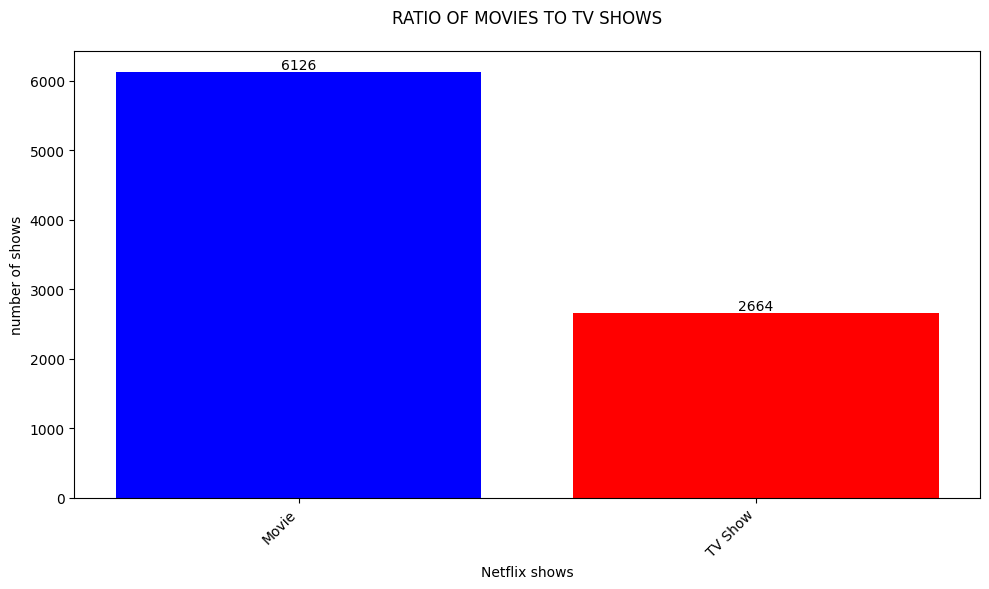

In [29]:
df_p = df['type'].value_counts()

plot_barchart(df_p.values, df_p.index, chart_type='vertical', title='RATIO OF MOVIES TO TV SHOWS',
              xlabel='Netflix shows', ylabel='number of shows', colors=['blue', 'red'],
              figsize=(10, 6), label_rotation=45,
              value_fontsize=10, bar_width=0.8)


We may conclude that Netflix favours movies over television shows because there is a notable discrepancy between the two. This could be because television shows require a lot more time and resources than movies.

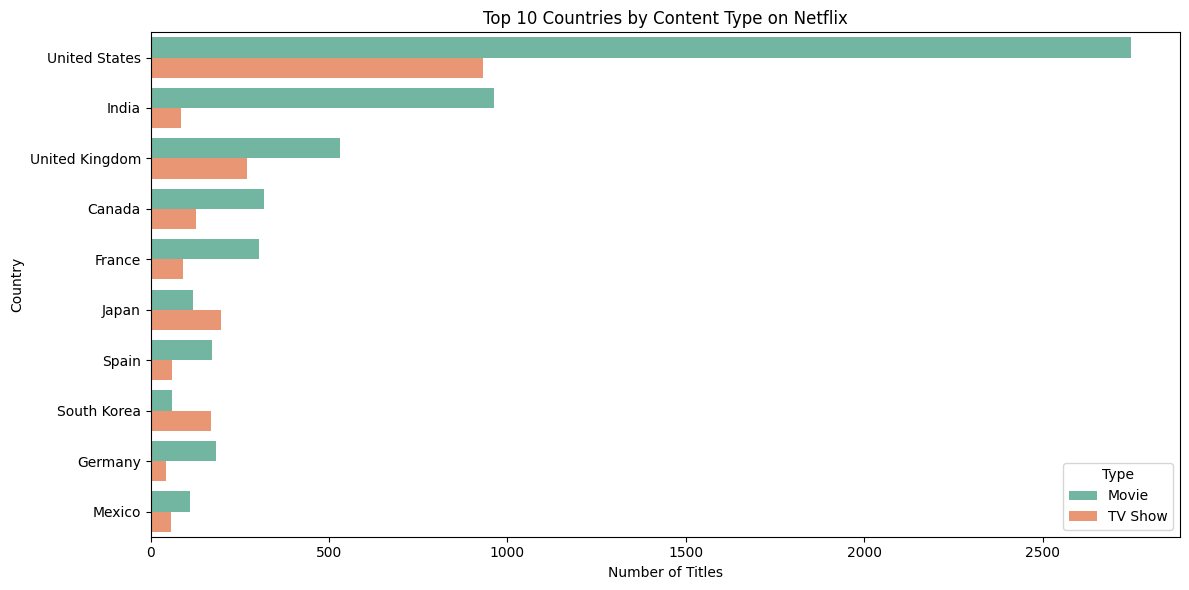

In [27]:
df_ct = df[['country', 'type']].dropna()
df_ct['country'] = df_ct['country'].str.split(', ')
df_ct = df_ct.explode('country')
df_ct=df_ct[df_ct['country'] != 'unknown']
top_countries = df_ct['country'].value_counts().nlargest(10).index
df_ct_top = df_ct[df_ct['country'].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.countplot(data=df_ct_top, y='country', hue='type', order=top_countries, palette='Set2')
plt.title('Top 10 Countries by Content Type on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.legend(title='Type')
plt.tight_layout()
plt.show()


The United States produces the most films and television series, followed by India, which produces a very small amount of television series. This indicates that, according to Netflix, Indians do not enjoy television shows as much as people in other nations, while Americans enjoy both but still incline towards films.

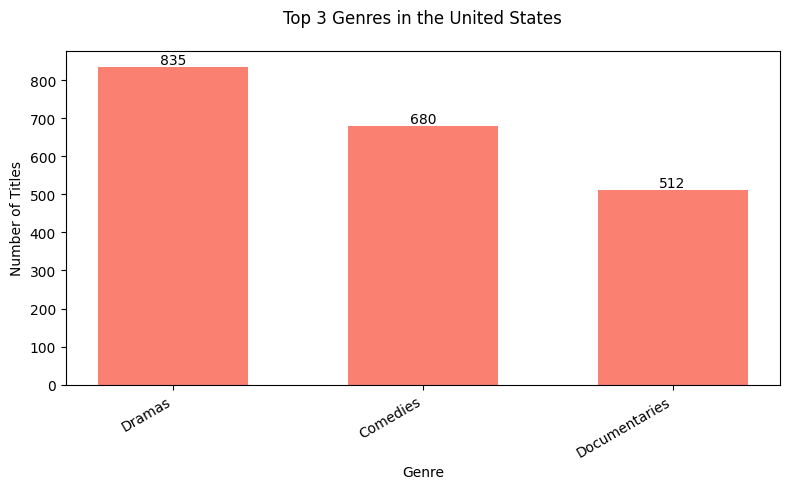

In [31]:
# Step 1: Filter rows with 'United States' in the country column
df_us = df[df['country'].str.contains('United States', na=False)].copy()

# Step 2: Split multiple genres and explode
df_us['listed_in'] = df_us['listed_in'].str.split(', ')
df_us = df_us.explode('listed_in')

# Step 3: Count top 3 genres
top_us_genres = df_us['listed_in'].value_counts().head(3)

# Step 4: Plot using your custom function
plot_barchart(
    data=top_us_genres.values,
    labels=top_us_genres.index,
    chart_type='vertical',
    title='Top 3 Genres in the United States',
    xlabel='Genre',
    ylabel='Number of Titles',
    colors='salmon',
    figsize=(8, 5),
    label_rotation=30,
    value_fontsize=10,
    bar_width=0.6
)


Since the US is the top country for Netflix services, it primarily offers comedies, dramas, and light-hearted documentaries.

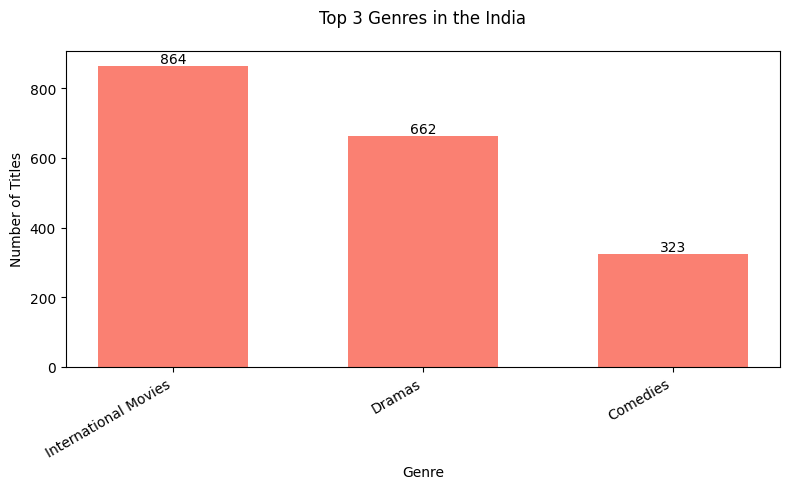

In [32]:
# Step 1: Filter rows with 'United States' in the country column
df_us = df[df['country'].str.contains('India', na=False)].copy()

# Step 2: Split multiple genres and explode
df_us['listed_in'] = df_us['listed_in'].str.split(', ')
df_us = df_us.explode('listed_in')

# Step 3: Count top 3 genres
top_us_genres = df_us['listed_in'].value_counts().head(3)

# Step 4: Plot using your custom function
plot_barchart(
    data=top_us_genres.values,
    labels=top_us_genres.index,
    chart_type='vertical',
    title='Top 3 Genres in the India',
    xlabel='Genre',
    ylabel='Number of Titles',
    colors='salmon',
    figsize=(8, 5),
    label_rotation=30,
    value_fontsize=10,
    bar_width=0.6
)


Netflix produces more comedies, dramas, and films because India, the second-largest Netflix user base, imports these types of content.  Given that Netflix has a far higher quantity of TV series in India than in other countries, we might infer that the streaming service creates genre specifically for television programming.

**TOP DIRECTOR**

In [33]:
print(df['director'].nunique())


4527


In this dataset, there are 4527 distinct directors. There are far too many unknown filmmakers.   Let's keep the unknown out of the discussions for the time being.

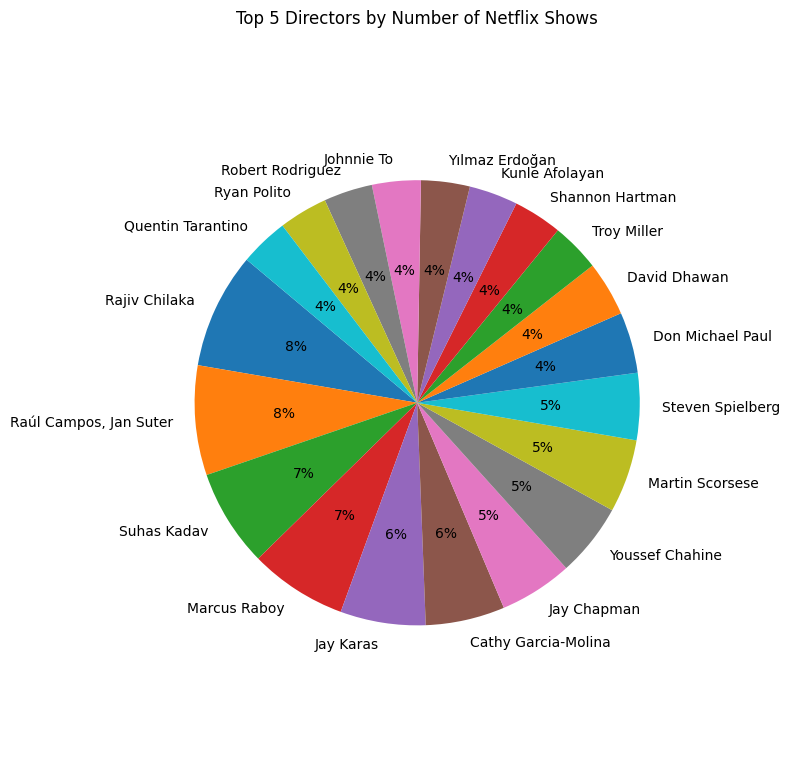

In [34]:
# Filter out any variation of 'Unknown' (case insensitive)
df_known_directors = df[~df['director'].str.lower().str.contains('unknown')]

# Get top 5 directors
top_directors = (df_known_directors.groupby('director')
                                  .size()
                                  .reset_index(name='count')
                                  .sort_values(by='count', ascending=False)
                                  .head(20))

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_directors['count'],
        labels=top_directors['director'],
        autopct='%1.0f%%',
        startangle=140)
plt.title('Top 5 Directors by Number of Netflix Shows')
plt.axis('equal')
plt.tight_layout()
plt.show()

Netflix has made reasonable investments in the majority of the top filmmakers seen in the graph, however some have more opportunities than others with minimal difference.

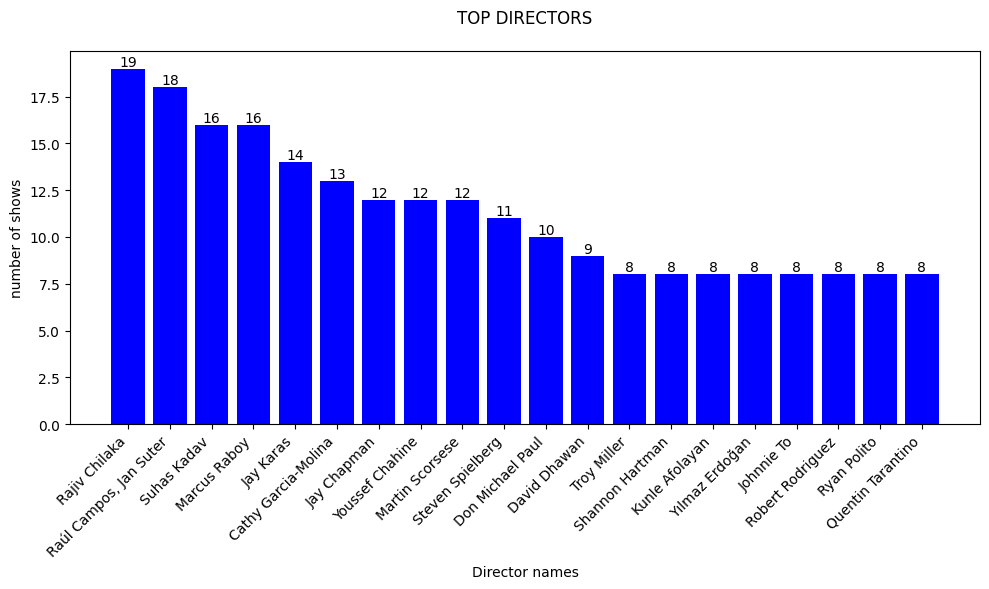

In [35]:
df_p=df['type'].value_counts()



plot_barchart(top_directors['count'],top_directors['director'], chart_type='vertical', title='TOP DIRECTORS',
                 xlabel='Director names', ylabel='number of shows', colors='blue',
                 figsize=(10, 6), label_rotation=45,
                 value_fontsize=10, bar_width=0.8)

This leads us to the conclusion that Netflix loves filmmakers like Rajiv Chilaka and Jan Suter because they have a lot more shows than others, which may also indicate that viewers enjoy their direction.

###**TOP MOVIE DIRECTORS**

In [36]:
import matplotlib.pyplot as plt

def top_director_plot(df, content_type='Movie'):
    dfp = df.copy()

    # Remove unknown and NaN directors
    dfp = dfp[dfp['director'].notna()]
    dfp = dfp[~dfp['director'].str.lower().str.contains('unknown')]

    # Explode multi-director rows
    dfp['director'] = dfp['director'].str.split(', ')
    dfp = dfp.explode('director')

    # Count total titles for each director (any type)
    total_counts = dfp['director'].value_counts()

    # Count content-type-specific titles for each director
    type_counts = dfp[dfp['type'] == content_type]['director'].value_counts()

    # Get top 10 based on content_type count
    top_directors = type_counts.head(10).index

    # Filter both series to include only top 10 directors
    type_counts_top = type_counts[top_directors]
    total_counts_top = total_counts[top_directors]

    # Create grouped bar chart
    x = range(len(top_directors))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x, type_counts_top.values, width=width, label=content_type, color='skyblue')
    plt.bar([i + width for i in x], total_counts_top.values, width=width, label='Total', color='gray')

    plt.xticks([i + width/2 for i in x], top_directors, rotation=45, ha='right')
    plt.xlabel('Director')
    plt.ylabel('Number of Titles')
    plt.title(f'Top 10 Directors by Number of {content_type}s vs Total Titles')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
top_director_plot(df,'TV Show')


In [ ]:
top_director_plot(df,'Movie')


We can infer from the two graphs above that Netflix and filmmakers prefer to produce films.  We can see that the total number of published films and TV series is equal to the total number of films because television shows require more director time than films. with certain exceptions, such as  Marcus Raboy

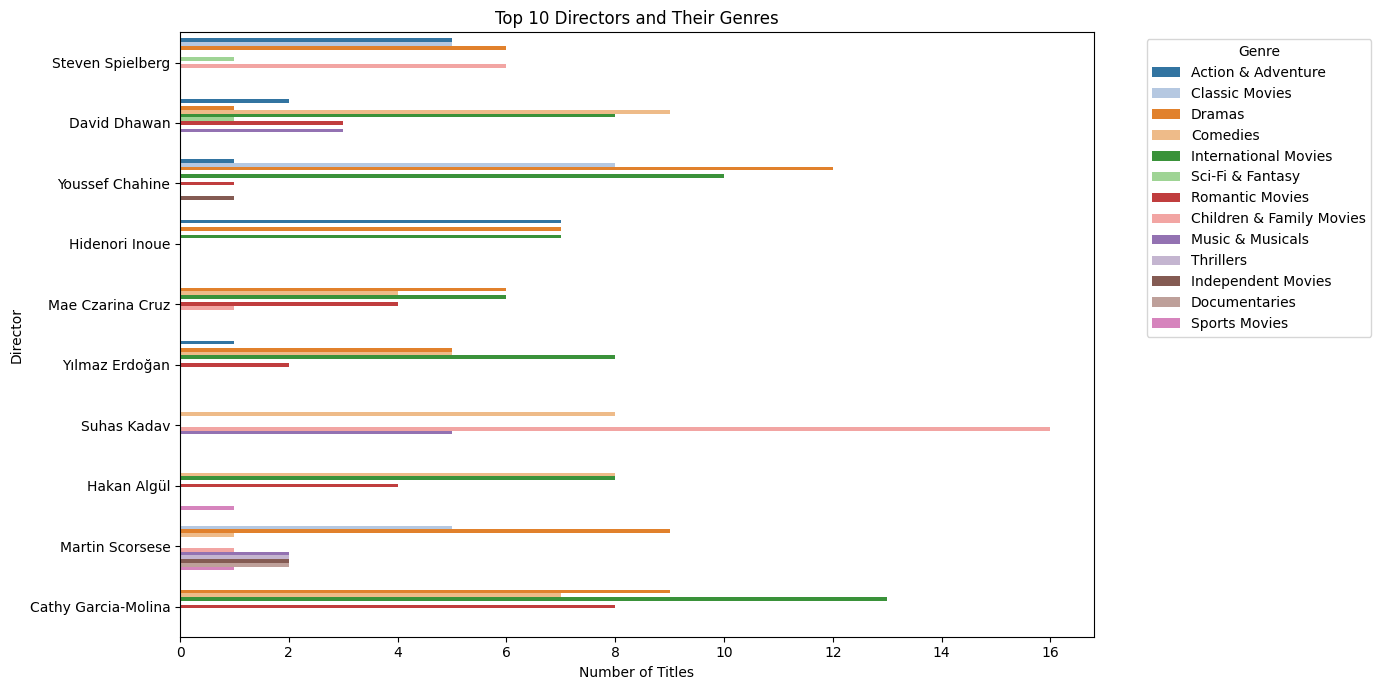

In [37]:
df_dg = df[['director', 'listed_in']].dropna()

# Remove rows where 'director' or 'listed_in' is "Unknown"
df_dg = df_dg[~df_dg['director'].str.lower().str.contains('unknown')]
df_dg = df_dg[~df_dg['listed_in'].str.lower().str.contains('unknown')]

# Split genres and explode
df_dg['listed_in'] = df_dg['listed_in'].str.split(', ')
df_dg = df_dg.explode('listed_in')

# Get top 10 directors
top_directors = df_dg['director'].value_counts().nlargest(10).index
df_dg_top = df_dg[df_dg['director'].isin(top_directors)]

# Plot
plt.figure(figsize=(14,7))
sns.countplot(data=df_dg_top, y='director', hue='listed_in', palette='tab20')
plt.title('Top 10 Directors and Their Genres')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The majority of Suhas Kadav's family and children's films, Catherine Garcia Molina's foreign flicks, and Youseff Chahinne's dramas

###**FAMOUS  ACTOR**

Let's exclude all the other minor artists and attempt to focus on the primary cast, as the first name in the list of characters typically plays the lead role.

In [38]:
df['cast'] = df['cast'].str.split(',').str[0].str.strip()

In [39]:
df['cast'].nunique()

5396

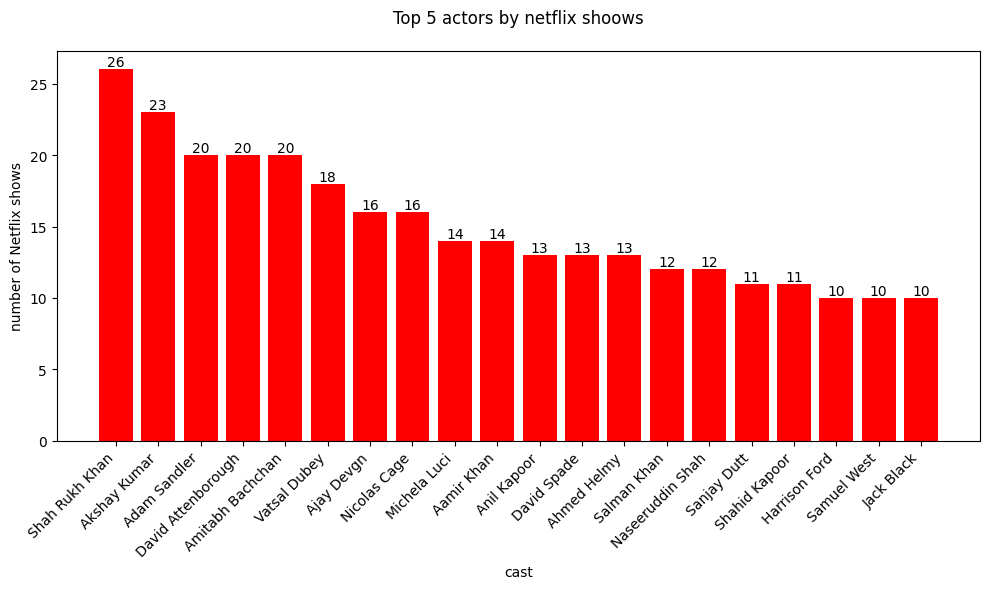

In [40]:
df_known_cast= df[~df['cast'].str.lower().str.contains('unknown')]


top_cast = (df_known_cast.groupby('cast')
                                  .size()
                                  .reset_index(name='count')
                                  .sort_values(by='count', ascending=False)
                                  .head(20))
plot_barchart(top_cast['count'], top_cast['cast'], chart_type='vertical', title='Top 5 actors by netflix shoows',
                 xlabel='cast', ylabel='number of Netflix shows', colors='red',
                 figsize=(10, 6), label_rotation=45,
                 value_fontsize=10, bar_width=0.8)


Actors like david,john micheal appears in 35+ shows, indicating a strong partnership with Netflix or high reusability in content. Further investigation could link this to regional popularity or genre-based casting patterns.

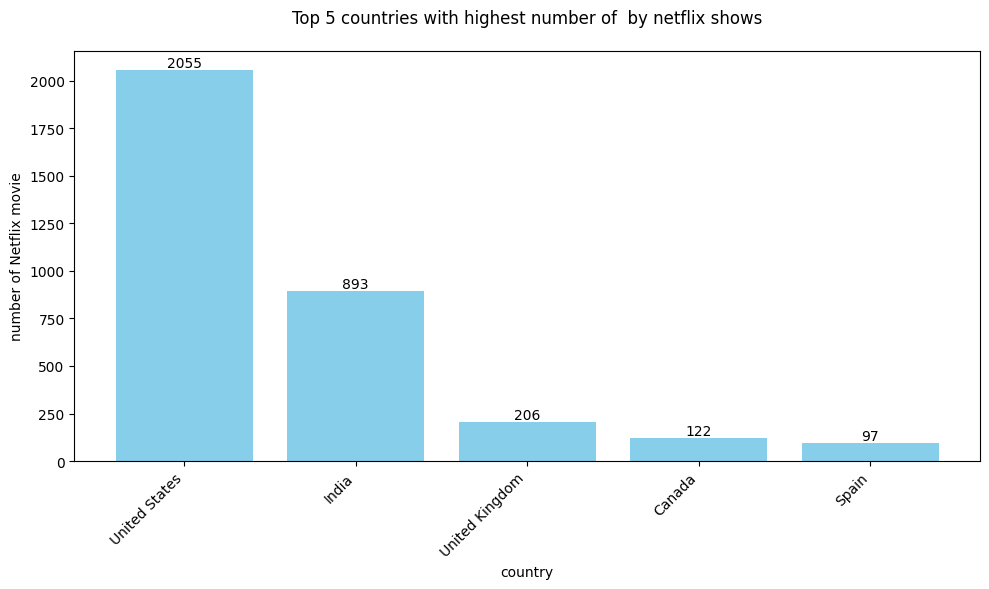

In [41]:

df_known_movie_country = df[
    (df['type'] == 'Movie') &
    (~df['country'].str.lower().str.contains('unknown', na=False))
]

# Group by country and count
top_movie_country = (
    df_known_movie_country.groupby('country')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(5)
)
plot_barchart(top_movie_country['count'], top_movie_country['country'], chart_type='vertical', title='Top 5 countries with highest number of  by netflix shows',
                 xlabel='country', ylabel='number of Netflix movie', colors='skyblue',
                 figsize=(10, 6), label_rotation=45,
                 value_fontsize=10, bar_width=0.8)



The United States is the top producer of both films and television series, while South Korea created a lot more television series and others stayed the same. India produces less television series than films.

###**RELEASE YEAR**

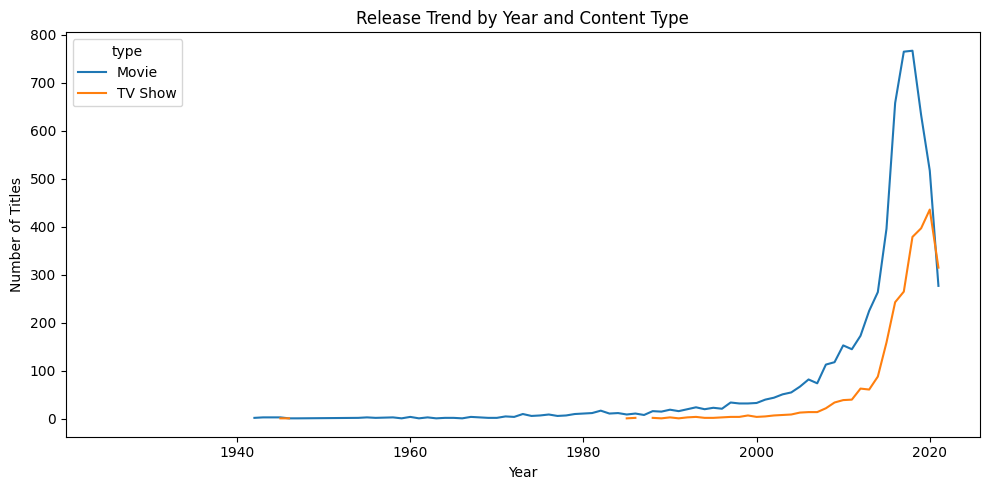

In [42]:
df.groupby(['release_year', 'type']).size().unstack().plot(kind='line', figsize=(10,5))
plt.title('Release Trend by Year and Content Type')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

Early technology led to low production, which later increased rapidly before declining as a result of the corona

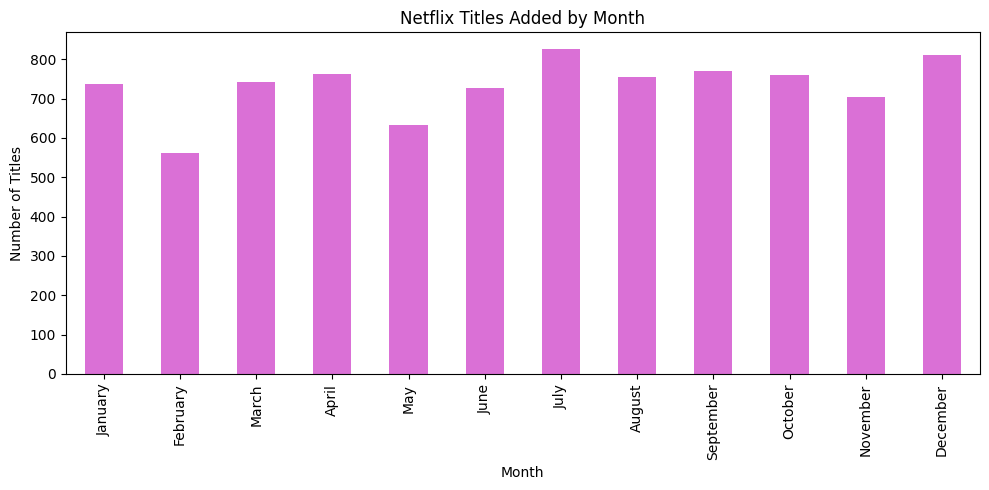

In [43]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['month_added'] = df['date_added'].dt.month_name()

monthly = df['month_added'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

monthly.plot(kind='bar', figsize=(10, 5), color='orchid')
plt.title('Netflix Titles Added by Month')
plt.xlabel('Month')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()



Since audiences are more eager to watch, most shows are released during the end of season and festival seasons.

###**GENRE**

In [45]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",September
1,s2,TV Show,Blood & Water,unknown,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",September
2,s3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila,unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,September
3,s4,TV Show,Jailbirds New Orleans,unknown,unknown,unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",September
4,s5,TV Show,Kota Factory,unknown,Mayur More,India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,September


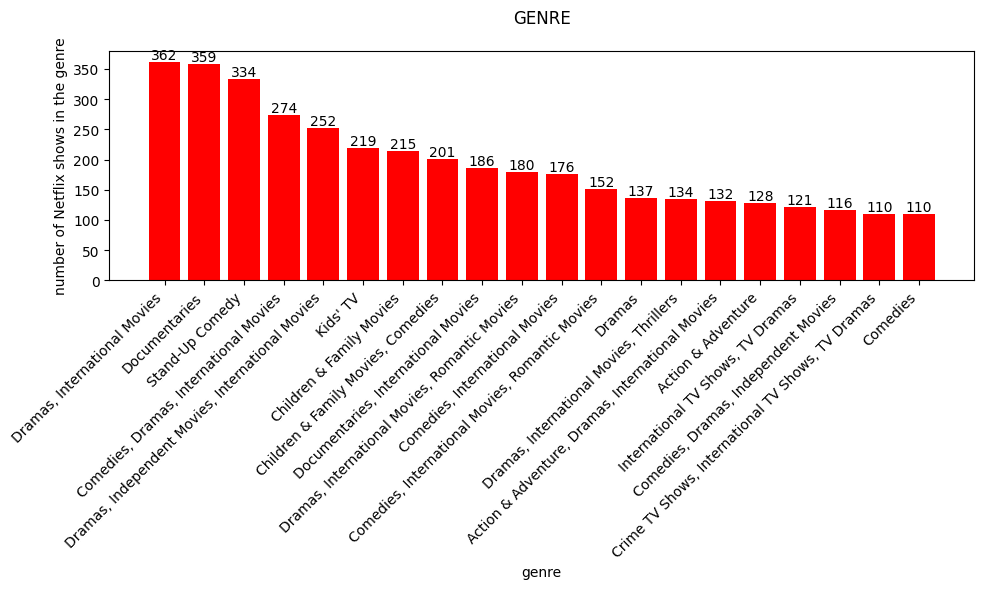

In [44]:
df_known_genre= df[~df['listed_in'].str.lower().str.contains('unknown')]


top_genres = (df_known_genre.groupby('listed_in')
                                  .size()
                                  .reset_index(name='count')
                                  .sort_values(by='count', ascending=False)
                                  .head(20))
plot_barchart(top_genres['count'], top_genres['listed_in'], chart_type='vertical', title='GENRE',
                 xlabel='genre', ylabel='number of Netflix shows in the genre', colors='red',
                 figsize=(10, 6), label_rotation=45,
                 value_fontsize=10, bar_width=0.8)

Netflix's most sought-after genres are international films, dramas, and comedies, which makes sense given that these are the genres most frequently viewed in the top countries, according to Netflix.

###**RATING**

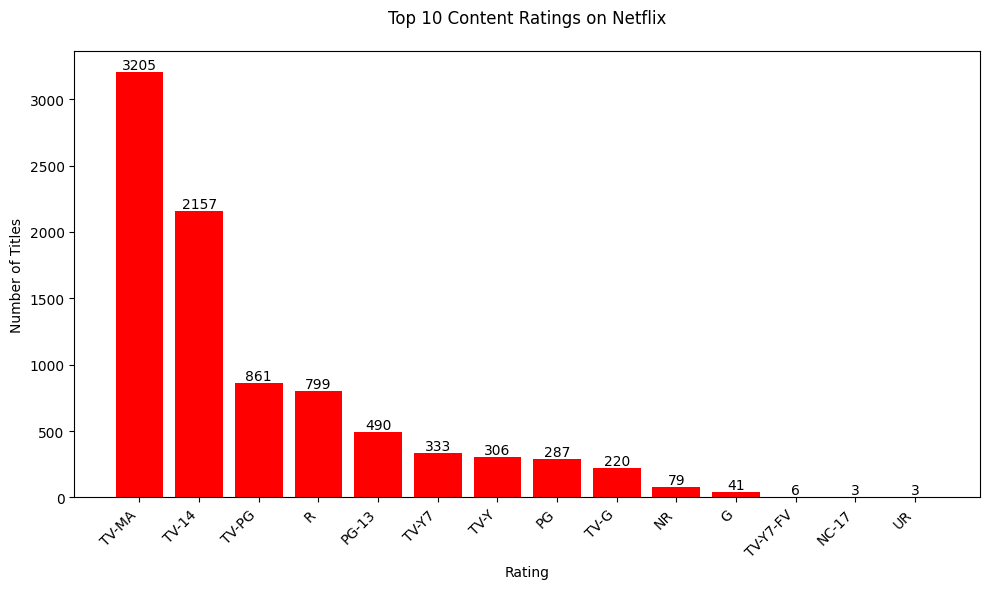

In [46]:
rating_counts = df['rating'].value_counts().head(20).reset_index()
rating_counts.columns = ['rating', 'count']




plot_barchart(rating_counts['count'], rating_counts['rating'], chart_type='vertical', title='Top 10 Content Ratings on Netflix',
                 xlabel='Rating', ylabel='Number of Titles', colors='red',
                 figsize=(10, 6), label_rotation=45,
                 value_fontsize=10, bar_width=0.8)


TV-MA is the most watched rating which can also mean netflix is used by adults more thus adults are its main customer base.

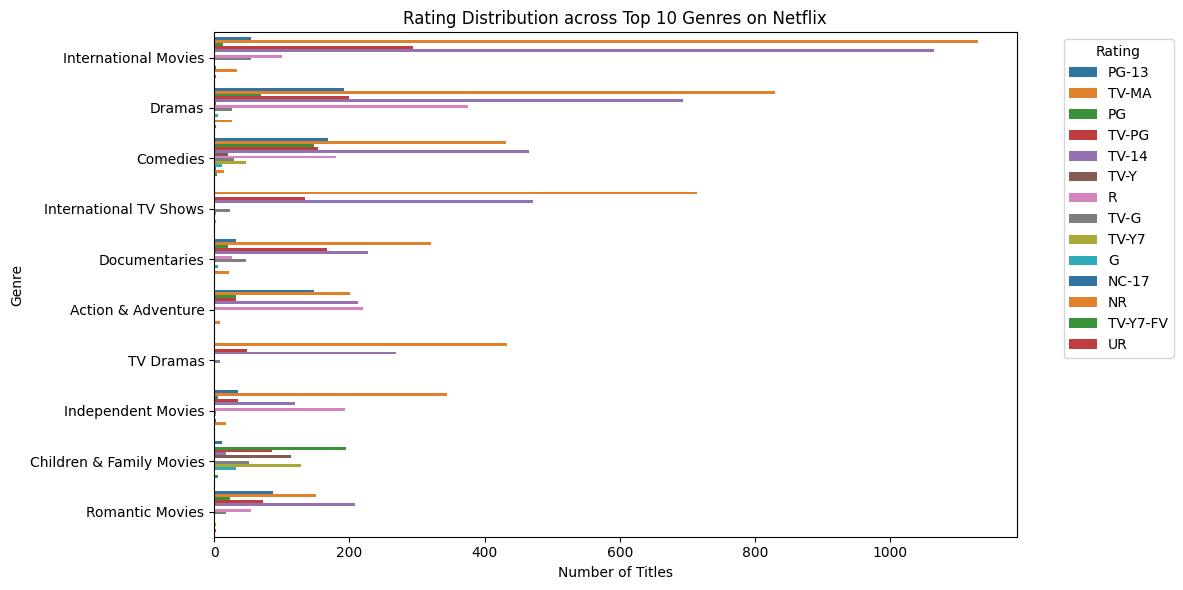

In [47]:
df_genre_rating = df[['listed_in', 'rating']].dropna()

# Split multi-genre entries and explode into rows
df_genre_rating['listed_in'] = df_genre_rating['listed_in'].str.split(', ')
df_genre_rating = df_genre_rating.explode('listed_in')

# Optionally limit to top 10 genres
top_genres = df_genre_rating['listed_in'].value_counts().nlargest(10).index
df_top = df_genre_rating[df_genre_rating['listed_in'].isin(top_genres)]
import matplotlib.pyplot as plt
import seaborn as sns
# Create count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df_top, y='listed_in', hue='rating', order=top_genres, palette='tab10')
plt.title('Rating Distribution across Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Due to its international movies,dramas,tv dramas  many other genres having mostly TV-MA rating, TV-MA productions are much more popular than others.

###**DURATION**

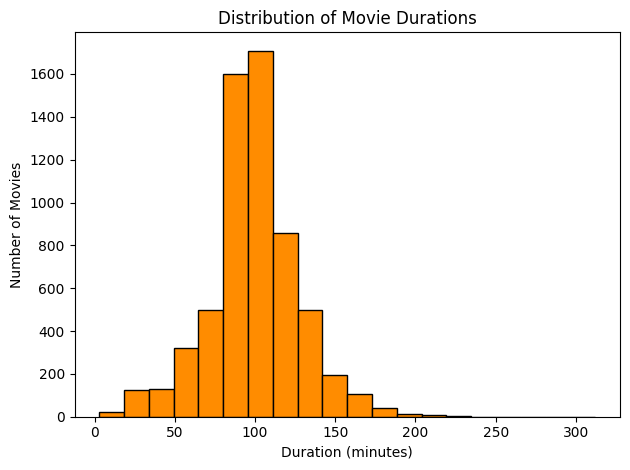

In [48]:
# Filter only movies
df_movies = df[df['type'] == 'Movie'].copy()

# Extract the numeric duration
df_movies['duration_min'] = df_movies['duration'].str.extract('(\d+)').astype(float)

# Plot histogram of movie durations
plt.hist(df_movies['duration_min'], bins=20, color='darkorange', edgecolor='black')
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()



We may estimate that the shows last for about 100 minutes.

Production rises over the holidays or at the end of the season.

##**Recommendation system**

In [50]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",September
1,s2,TV Show,Blood & Water,unknown,Ama Qamata,South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",September
2,s3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila,unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,September
3,s4,TV Show,Jailbirds New Orleans,unknown,unknown,unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",September
4,s5,TV Show,Kota Factory,unknown,Mayur More,India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,September


In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combine key features into a single text column
df['combined'] = (
    df['title'] + ' ' +
    df['director'] + ' ' +
    df['cast'] + ' ' +
    df['listed_in'] + ' ' +
    df['description']
)

# Vectorize the combined text
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined'])

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create reverse mapping of titles to DataFrame indices
indices = pd.Series(df.index, index=df['title'].str.lower()).drop_duplicates()

# Recommendation function
def recommend(title, num=5):
    title = title.lower()
    if title not in indices:
        return f"'{title}' not found in the dataset."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num+1]
    movie_indices = [i[0] for i in sim_scores]

    return df[['title', 'listed_in', 'description', 'month_added']].iloc[movie_indices]

# Example usage
print(recommend("Dive Club"))


                                    title  \
3840                          The Society   
1                           Blood & Water   
3664  Anohana: The Flower We Saw That Day   
4129                                 Safe   
1639                      Heartbreak High   

                                              listed_in  \
3840                           TV Dramas, Teen TV Shows   
1       International TV Shows, TV Dramas, TV Mysteries   
3664  Anime Series, International TV Shows, Teen TV ...   
4129  British TV Shows, Crime TV Shows, Internationa...   
1639   International TV Shows, TV Dramas, Teen TV Shows   

                                            description month_added  
3840  When everyone else mysteriously vanishes from ...         May  
1     After crossing paths at a party, a Cape Town t...   September  
3664  A teen haunted by the spirit of an old friend ...        July  
4129  After his teenage daughter goes missing, a wid...    February  
1639  A crash course on 

##**Summary & Insights**

- Netflix's content library is heavily skewed toward **movies**, which make up the majority of titles, possibly due to their shorter production cycles compared to TV shows.



- The most prolific directors include both globally recognized filmmakers and regional content contributors, though many titles lack credited directors.



- **United States** and **India** are the leading countries in terms of total content, with **South Korea** producing a notably high number of TV shows.



- The most frequent actors appearing in Netflix content tend to be from regional markets, reflecting Netflix’s diverse and localized content strategy.


- A sharp rise in releases occurred post-2015, peaking around 2018–2019, followed by a dip likely due to the global pandemic.


- Content additions show a trend of increasing uploads during year-end months, possibly to align with holiday demand.


- Missing values were carefully handled (e.g., using `'unknown'` or dropping), and visualizations were used to support every major insight.

---

This project demonstrates practical skills in:
- Data cleaning (handling missing/dirty values)
- Grouping and filtering using Pandas
- Visualizing trends using pie charts, bar charts, and time plots
- Asking and answering real business-like questions with data




Country + Type

Year + Type

Director + Genre (if available)